# 1. Space carving

In [57]:
import numpy as np
import scipy.io as sio
import argparse
from space_carving.camera import Camera
from space_carving.plotting import *

import math

# A very simple, but useful method to take the difference between the
# first and second element (usually for 2D vectors)
def diff(x):
    return x[1] - x[0]


'''
FORM_INITIAL_VOXELS  create a basic grid of voxels ready for carving

Arguments:
    xlim - The limits of the x dimension given as [xmin xmax]

    ylim - The limits of the y dimension given as [ymin ymax]

    zlim - The limits of the z dimension given as [zmin zmax]

    num_voxels - The approximate number of voxels we desire in our grid

Returns:
    voxels - An ndarray of size (N, 3) where N is approximately equal the 
        num_voxels of voxel locations.

    voxel_size - The distance between the locations of adjacent voxels
        (a voxel is a cube)

Our initial voxels will create a rectangular prism defined by the x,y,z
limits. Each voxel will be a cube, so you'll have to compute the
approximate side-length (voxel_size) of these cubes, as well as how many
cubes you need to place in each dimension to get around the desired
number of voxel. This can be accomplished by first finding the total volume of
the voxel grid and dividing by the number of desired voxels. This will give an
approximate volume for each cubic voxel, which you can then use to find the 
side-length. The final "voxels" output should be a ndarray where every row is
the location of a voxel in 3D space.
'''
def form_initial_voxels(xlim, ylim, zlim, num_voxels):
    volume = (abs(xlim[1] - xlim[0]) *
              abs(ylim[1] - ylim[0]) *
              abs(zlim[1] - zlim[0]))
    
    #print (\"Volume: %f\" % volume)
    voxel_volume = 1. * volume / num_voxels
    #print (\"Voxel Volume: %f\" % voxel_volume)
    voxel_size = voxel_volume ** (1. / 3.0)
    #print (\"Voxel size: %f\" % voxel_size)
    
    #voxel_size = math.ceil(voxel_size)
    #print (\"Voxel size: %d\" % voxel_size)
    
    x_voxels = int(math.floor(abs(xlim[1] - xlim[0]) / voxel_size))
    y_voxels = int(math.floor(abs(ylim[1] - ylim[0]) / voxel_size))
    z_voxels = int(math.floor(abs(zlim[1] - zlim[0]) / voxel_size))
    
    total_voxels = x_voxels * y_voxels * z_voxels
    #print (\"Total: %d, requested: %d\" % (total_voxels, num_voxels))
    voxels = np.zeros((total_voxels, 3))
    idx = 0
    for x in range(0, x_voxels):
        for y in range(0, y_voxels):
            for z in range(0, z_voxels):
                voxels[idx, :] = np.array([x * voxel_size, y * voxel_size, z * voxel_size])
                idx = idx + 1
    
    #print (\"Idx: %d\" % idx)
    return (voxels, voxel_size)


'''
GET_VOXEL_BOUNDS: Gives a nice bounding box in which the object will be carved
from. We feed these x/y/z limits into the construction of the inital voxel
cuboid. 

Arguments:
    cameras - The given data, which stores all the information
        associated with each camera (P, image, silhouettes, etc.)

    estimate_better_bounds - a flag that simply tells us whether to set tighter
        bounds. We can carve based on the silhouette we use.

    num_voxels - If estimating a better bound, the number of voxels needed for
        a quick carving.

Returns:
    xlim - The limits of the x dimension given as [xmin xmax]

    ylim - The limits of the y dimension given as [ymin ymax]

    zlim - The limits of the z dimension given as [zmin zmax]

The current method is to simply use the camera locations as the bounds. In the
section underneath the TODO, please implement a method to find tigther bounds:
One such approach would be to do a quick carving of the object on a grid with 
very few voxels. From this coarse carving, we can determine tighter bounds. Of
course, these bounds may be too strict, so we should have a buffer of one 
voxel_size around the carved object. 
'''
def get_voxel_bounds(cameras, estimate_better_bounds = False, num_voxels = 4000):
    camera_positions = np.vstack([c.T for c in cameras])
    xlim = [camera_positions[:,0].min(), camera_positions[:,0].max()]
    ylim = [camera_positions[:,1].min(), camera_positions[:,1].max()]
    zlim = [camera_positions[:,2].min(), camera_positions[:,2].max()]

    # For the zlim we need to see where each camera is looking. 
    camera_range = 0.6 * np.sqrt(diff( xlim )**2 + diff( ylim )**2)
    for c in cameras:
        viewpoint = c.T - camera_range * c.get_camera_direction()
        zlim[0] = min( zlim[0], viewpoint[2] )
        zlim[1] = max( zlim[1], viewpoint[2] )

    # Move the limits in a bit since the object must be inside the circle
    xlim = xlim + diff(xlim) / 4 * np.array([1, -1])
    ylim = ylim + diff(ylim) / 4 * np.array([1, -1])

    if estimate_better_bounds:        
        voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, num_voxels)
        # print ("Voxels\n", voxels)
        voxels = carve(voxels, cameras[0])
        # print ("voxels\n", voxels.shape)

        x_min = voxels[:, 0].min() - voxel_size
        x_max = voxels[:, 0].max() + voxel_size
        y_min = voxels[:, 1].min() - voxel_size
        y_max = voxels[:, 1].max() + voxel_size
        z_min = voxels[:, 2].min() - voxel_size
        z_max = voxels[:, 2].max() + voxel_size
        
        xlim = [x_min, x_max]
        ylim = [y_min, y_max]
        zlim = [z_min, z_max]

    return xlim, ylim, zlim
    

'''
CARVE: carves away voxels that are not inside the silhouette contained in 
    the view of the camera. The resulting voxel array is returned.

Arguments:
    voxels - an Nx3 matrix where each row is the location of a cubic voxel

    camera - The camera we are using to carve the voxels with. Useful data
        stored in here are the "silhouette" matrix, "image", and the
        projection matrix "P". 

Returns:
    voxels - a subset of the argument passed that are inside the silhouette
'''
def carve(voxels, camera):
    # Project the coordinates of the voxels onto the image.
    ones = np.ones((voxels.shape[0], 1))
    voxels_hg = np.concatenate((voxels, ones), axis=1)
    projected_voxels = camera.P.dot(voxels_hg.T).T

    #print ("Voxels\n", voxels[[0, 1, 2, 3], :])    
    #print ("Projected\n", projected_voxels[[0, 1, 2, 3], :])    

    multiplier = 1.0 / projected_voxels[:, 2]
    multiplier = np.reshape(multiplier, (projected_voxels.shape[0], 1))

    #print ("Multiplier\n", multiplier.shape)
    multiplier = np.matlib.repmat(multiplier, 1, 3)
    #print ("Multiplier\n", multiplier[[0,1,2,3], :])
    
    projected_voxels = projected_voxels * multiplier
    projected_voxels = np.around(projected_voxels[:, [0, 1]]).astype(int)
    #print ("Projected_voxels\n", projected_voxels[[0, 1, 2, 3], :])
    
    # Throw away voxels out of the bounds of the image or not in the silhouette
    image_shape = camera.image.shape
    def in_silhouette(coords):
        if (coords[0] >= 0 and coords[0] < image_shape[1]
            and coords[1] >= 0 and coords[1] < image_shape[0]
            and camera.silhouette[coords[1], coords[0]] == 1):
            return 1
        return 0
    
    in_silhouette_voxels = np.apply_along_axis(in_silhouette, 1, projected_voxels)
    
    #print ("in_silhouette_voxels.shape\n", in_silhouette_voxels.shape)
    #print ("in_silhouette_voxels\n", in_silhouette_voxels[ in_silhouette_voxels == 1])
    
    return voxels[in_silhouette_voxels == 1, :]
    
    
'''
ESTIMATE_SILHOUETTE: Uses a very naive and color-specific heuristic to generate
the silhouette of an object

Arguments:
    im - The image containing a known object. An ndarray of size (H, W, C).

Returns:
    silhouette - An ndarray of size (H, W), where each pixel location is 0 or 1.
        If the (i,j) value is 0, then that pixel location in the original image 
        does not correspond to the object. If the (i,j) value is 1, then that
        that pixel location in the original image does correspond to the object.
'''
def estimate_silhouette(im):
    return np.logical_and(im[:,:,0] > im[:,:,2], im[:,:,0] > im[:,:,1] )


frames = sio.loadmat('space_carving/frames.mat')['frames'][0]
cameras = [Camera(x) for x in frames]

estimate_better_bounds = False
use_true_silhouette = True

# Generate the silhouettes based on a color heuristic
if not use_true_silhouette:
    for i, c in enumerate(cameras):
        c.true_silhouette = c.silhouette
        c.silhouette = estimate_silhouette(c.image)
        if i == 0:
            plt.figure()
            plt.subplot(121)
            plt.imshow(c.true_silhouette, cmap = 'gray')
            plt.title('True Silhouette')
            plt.subplot(122)
            plt.imshow(c.silhouette, cmap = 'gray')
            plt.title('Estimated Silhouette')
            plt.show()


## (a) Generate voxel grid

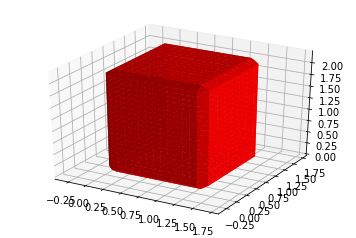

In [58]:
# Generate the voxel grid
# You can reduce the number of voxels for faster debugging, but
# make sure you use the full amount for your final solution
num_voxels = 6e6
xlim, ylim, zlim = get_voxel_bounds(cameras, estimate_better_bounds)

# This part is simply to test forming the initial voxel grid
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, 4000)
plot_surface(voxels)
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, num_voxels)


## (b) Carving from one camera

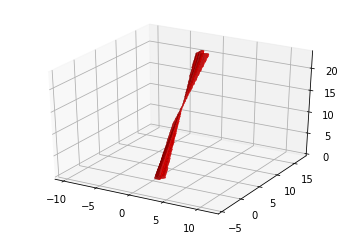

In [59]:
# Test the initial carving
voxels = carve(voxels, cameras[0])
if use_true_silhouette:
    plot_surface(voxels)


## (c) Carving from multiple cameras

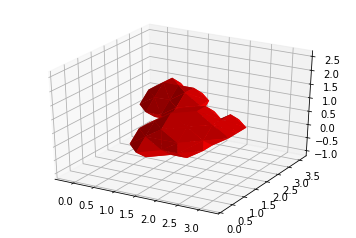

In [60]:
# Result after all carvings
for c in cameras:
    voxels = carve(voxels, c)  
plot_surface(voxels, voxel_size)


## (d) Better bounds

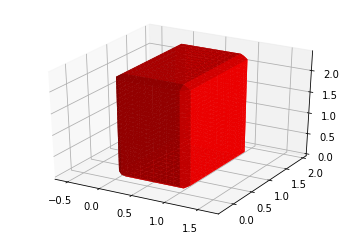

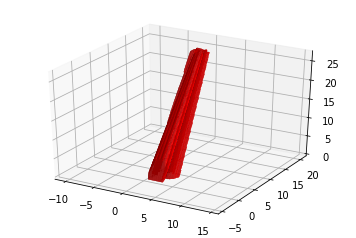

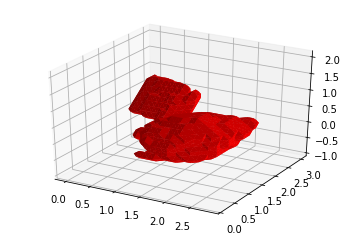

In [61]:
estimate_better_bounds = True

# Generate the voxel grid
# You can reduce the number of voxels for faster debugging, but
# make sure you use the full amount for your final solution
num_voxels = 6e6
xlim, ylim, zlim = get_voxel_bounds(cameras, estimate_better_bounds, num_voxels=4312)

# This part is simply to test forming the initial voxel grid
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, 4000)
plot_surface(voxels)
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, num_voxels)

# Test the initial carving
voxels = carve(voxels, cameras[0])
if use_true_silhouette:
    plot_surface(voxels)
    
# Result after all carvings
for c in cameras:
    voxels = carve(voxels, c)  
plot_surface(voxels, voxel_size)


## (e) Estimated silhouette

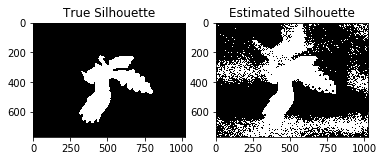

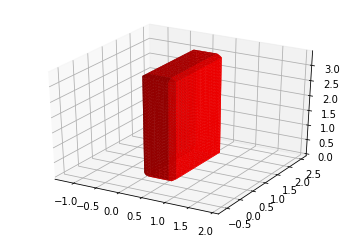

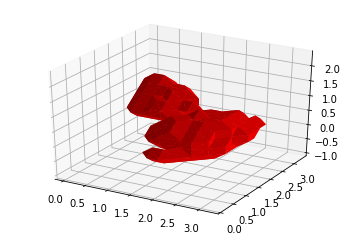

In [62]:
use_true_silhouette = False

# Generate the silhouettes based on a color heuristic
if not use_true_silhouette:
    for i, c in enumerate(cameras):
        c.true_silhouette = c.silhouette
        c.silhouette = estimate_silhouette(c.image)
        if i == 0:
            plt.figure()
            plt.subplot(121)
            plt.imshow(c.true_silhouette, cmap = 'gray')
            plt.title('True Silhouette')
            plt.subplot(122)
            plt.imshow(c.silhouette, cmap = 'gray')
            plt.title('Estimated Silhouette')
            plt.show()
            
estimate_better_bounds = True

# Generate the voxel grid
# You can reduce the number of voxels for faster debugging, but
# make sure you use the full amount for your final solution
num_voxels = 6e6
xlim, ylim, zlim = get_voxel_bounds(cameras, estimate_better_bounds, num_voxels=4312)

# This part is simply to test forming the initial voxel grid
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, 4000)
plot_surface(voxels)
voxels, voxel_size = form_initial_voxels(xlim, ylim, zlim, num_voxels)

# Test the initial carving
voxels = carve(voxels, cameras[0])
if use_true_silhouette:
    plot_surface(voxels)
    
# Result after all carvings
for c in cameras:
    voxels = carve(voxels, c)  
plot_surface(voxels, voxel_size)            

# (2) Single Object Recognition Via SIFT 

In [106]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import random
from single_object_recognition.utils import *
import math



## (a) Match keypoints

In [107]:
'''
MATCH_KEYPOINTS: Given two sets of descriptors corresponding to SIFT keypoints, 
find pairs of matching keypoints.

Note: Read Lowe's Keypoint matching, finding the closest keypoint is not
sufficient to find a match. thresh is the theshold for a valid match.

Arguments:
    descriptors1 - Descriptors corresponding to the first image. Each row
        corresponds to a descriptor. This is a ndarray of size (M_1, 128).

    descriptors2 - Descriptors corresponding to the second image. Each row
        corresponds to a descriptor. This is a ndarray of size (M_2, 128).

    threshold - The threshold which to accept from Lowe's Keypoint Matching
        algorithm

Returns:
    matches - An int ndarray of size (N, 2) of indices that for keypoints in 
        descriptors1 match which keypoints in descriptors2. For example, [7 5]
        would mean that the keypoint at index 7 of descriptors1 matches the
        keypoint at index 5 of descriptors2. Not every keypoint will necessarily
        have a match, so N is not the same as the number of rows in descriptors1
        or descriptors2. 
'''
def match_keypoints(descriptors1, descriptors2, threshold = 0.7):
    #print ("Descriptors1\n", descriptors1.shape)
    #print ("Descriptors2\n", descriptors2.shape)

    distances = np.zeros(descriptors1.shape[0] * descriptors2.shape[0])
    
    for idx1 in range(0, descriptors1.shape[0]):
        for idx2 in range(0, descriptors2.shape[0]):
            distances[descriptors2.shape[0] * idx1 + idx2] = (
                np.linalg.norm(descriptors1[idx1]-descriptors2[idx2]))
    
    matches = np.zeros((descriptors1.shape[0] * descriptors2.shape[0], 2))
    
    found_matches = 0

    for idx in range(0, descriptors1.shape[0]):
        idx_distances = distances[ idx * descriptors2.shape[0] : (idx + 1) * descriptors2.shape[0]]
        idx1 = np.argmin(idx_distances)
        dist_1 = idx_distances[idx1]
        idx_distances[idx1] = float("inf")
        idx2 = np.argmin(idx_distances)
        dist_2 = idx_distances[idx2]
        
        if dist_1/dist_2 < threshold:
            matches[found_matches, :] = np.array([idx, idx1])
            found_matches = found_matches + 1
        
    #print ("Found_matches", found_matches)
    return matches[0:found_matches, :].astype(int)




## (b) Refine match

In [108]:
'''
REFINE_MATCH: Filter out spurious matches between two images by using RANSAC
to find a projection matrix. 

Arguments:
    keypoints1 - Keypoints in the first image. Each row is a SIFT keypoint
        consisting of (u, v, scale, theta). Overall, this variable is a ndarray
        of size (M_1, 4).

    keypoints2 - Keypoints in the second image. Each row is a SIFT keypoint
        consisting of (u, v, scale, theta). Overall, this variable is a ndarray
        of size (M_2, 4).

    matches - An int ndarray of size (N, 2) of indices that indicate what
        keypoints from the first image (keypoints1)  match with the second 
        image (keypoints2). For example, [7 5] would mean that the keypoint at
        index 7 of keypoints1 matches the keypoint at index 5 of keypoints2). 
        Not every keypoint will necessarily have a  match, so N is not the same
        as the number of rows in keypoints1 or keypoints2. 

    reprojection_threshold - If the reprojection error is below this threshold,
        then we will count it as an inlier during the RANSAC process.

    num_iterations - The number of iterations we will run RANSAC for.

Returns:
    inliers - A vector of integer indices that correspond to the inliers of the
        final model found by RANSAC.

    model - The projection matrix H found by RANSAC that has the most number of
        inliers.
'''
def refine_match(keypoints1, keypoints2, matches, reprojection_threshold = 10,
        num_iterations = 1000):
    
    def find_matrix_H(p1, p2):
        A = np.zeros((2 * p1.shape[0], 9))
        for idx in range(0, p1.shape[0]):
            x= p1[idx, :]
            xp = p2[idx, :]
            a0 = np.array([
                x[0], x[1], 1, 0, 0, 0,
                -1 * xp[0] * x[0], -1 * xp[0] * x[1], -1 * xp[0]])
            a1 = np.array([
                0, 0, 0, x[0], x[1], 1,
                -1 * xp[1] * x[0], -1 * xp[1] * x[1], -1 * xp[1]])
            A[2 * idx, :] = a0
            A[2 * idx + 1, :] = a1

        U, S, V = np.linalg.svd(A)
        #print ("V.shape", V.shape)
        #print ("V:\n", V)
        H = np.reshape(V[8, :], (3, 3))
        return H

    MK1 = keypoints1[matches[:, 0], :]
    MK2 = keypoints2[matches[:, 1], :]
    
    ones = np.ones((matches.shape[0], 1))
    X1 = np.concatenate((MK1[:, [0, 1]], ones), axis=1)
    X2 = np.concatenate((MK2[:, [0, 1]], ones), axis=1)
    
    inliers = np.array([])
    model = None
    
    for it in range(0, num_iterations):
    #for it in range(0, 5):
        rand_indices = np.random.choice(matches.shape[0], 4)
        #print("RandIndices \n", rand_indices)
        p1 = X1[rand_indices, :]
        p2 = X2[rand_indices, :]
        H = find_matrix_H(p1, p2)
        Xh = H.dot(X1.T).T
        
        #print ("Xh.shape\n", Xh.shape)
        #print ("Xh:\n", Xh)
        Xh_z = Xh[:, 2]
        
        Xh_img = np.zeros_like(Xh)
        Xh_img[:, 0] = Xh[:, 0] * 1./Xh_z
        Xh_img[:, 1] = Xh[:, 1] * 1./Xh_z
        Xh_img[:, 2] = Xh[:, 2] * 1./Xh_z
        
        #print ("Xh_img.shape\n", Xh_img.shape)
        #print ("Xh_img:\n", Xh_img)
        error = Xh_img - X2
        #print ("Error:\n", error)
        error_norm = np.linalg.norm(error, axis = 1)
        #print ("Error_norm:\n", error_norm)
        error_norm_below_threshold = np.where(error_norm < reprojection_threshold)
        #print ("error_norm_below_threshold:\n", error_norm_below_threshold)
        if error_norm_below_threshold[0].shape[0] > inliers.shape[0]:
            #print ("Old number:\n", inliers.shape[0])
            #print ("New number:\n", error_norm_below_threshold[0].shape[0])
            inliers = error_norm_below_threshold[0]
            model = H
        
    return (inliers, model)


## (c) Theoretical properties of Ransac

## (d) 

## (e) GET_OBJECT_REGION

In [152]:
from functools import reduce

'''
GET_OBJECT_REGION: Get the parameters for each of the predicted object
bounding box in the image

Arguments:
    keypoints1 - Keypoints in the first image. Each row is a SIFT keypoint
        consisting of (u, v, scale, theta). Overall, this variable is a ndarray
        of size (M_1, 4).

    keypoints2 - Keypoints in the second image. Each row is a SIFT keypoint
        consisting of (u, v, scale, theta). Overall, this variable is a ndarray
        of size (M_2, 4).

    matches - An int ndarray of size (N, 2) of indices that indicate what
        keypoints from the first image (keypoints1)  match with the second 
        image (keypoints2). For example, [7 5] would mean that the keypoint at
        index 7 of keypoints1 matches the keypoint at index 5 of keypoints2). 
        Not every keypoint will necessarily have a  match, so N is not the same
        as the number of rows in keypoints1 or keypoints2.

    obj_bbox - An ndarray of size (4,) that contains [xmin, ymin, xmax, ymax]
        of the bounding box. Note that the point (xmin, ymin) is one corner of
        the box and (xmax, ymax) is the opposite corner of the box.

    thresh - The threshold we use in Hough voting to state that we have found
        a valid object region.

Returns:
    cx - A list of the x location of the center of the bounding boxes

    cy - A list of the y location of the center of the bounding boxes

    w - A list of the width of the bounding boxes

    h - A list of the height of the bounding boxes

    orient - A list f the orientation of the bounding box. Note that the 
        theta provided by the SIFT keypoint is inverted. You will need to
        re-invert it.
'''
def get_object_region(keypoints1, keypoints2, matches, obj_bbox, thresh = 2, 
        nbins = 4):
    bbox_c_x = np.mean(obj_bbox[[0, 2]])
    bbox_c_y = np.mean(obj_bbox[[1, 3]])
    bbox_w = abs(obj_bbox[2] - obj_bbox[0])
    bbox_h = abs(obj_bbox[3] - obj_bbox[1])
    
    MK1 = keypoints1[matches[:, 0], :]
    MK2 = keypoints2[matches[:, 1], :]
    
    X1 = MK1[:, 0]
    Y1 = MK1[:, 1]
    S1 = MK1[:, 2]
    O1 = MK1[:, 3]

    X2 = MK2[:, 0]
    Y2 = MK2[:, 1]
    S2 = MK2[:, 2]
    O2 = MK2[:, 3]
    
    SCALE = S2 * 1. / S1
    X1_offset = bbox_c_x-X1
    Y1_offset = bbox_c_y-Y1
    
    vote_w = bbox_w * SCALE
    vote_x = X2 +  (X1_offset * np.cos(O2 - O1) - Y1_offset * np.sin(O2 - O1))* SCALE
    vote_y = Y2 +  (X1_offset * np.sin(O2 - O1) + Y1_offset * np.cos(O2 - O1))* SCALE
    vote_o = np.mod(O2-O1+np.pi/4, 2 * np.pi)-np.pi/4
    
    def assign_bins(x, nbins):
        min_x = min(x)
        max_x = max(x)
        bin_size = (max_x - min_x) * 1. / nbins
        
        bins = np.ceil((x - min_x) * 1. / bin_size)
        bins[bins > (nbins - 1)] = nbins - 1
        return bins

    bw = assign_bins(vote_w, nbins)
    bx = assign_bins(vote_x, nbins)
    by = assign_bins(vote_y, nbins)
    bo = assign_bins(vote_o, nbins)

    #print ("bw\n", bw)
    #print ("bx\n", bx)
    #print ("by\n", by)
    #print ("bo\n", bo)
    
    cx = []
    cy = []
    w = []
    h = []
    orient = []

    for w_idx in range(0, nbins):
        for x_idx in range(0, nbins):
            for y_idx in range(0, nbins):
                for o_idx in range(0, nbins):
                    ind_w = np.where(bw == w_idx)
                    ind_x = np.where(bx == x_idx)
                    ind_y = np.where(by == y_idx)
                    ind_o = np.where(bo == o_idx)
                    ind = reduce(np.intersect1d, (ind_w, ind_x, ind_y, ind_o))
                    #print ("ind\n", ind)
                    if ind.shape[0] >= thresh:
                        cx.extend([np.mean(vote_x[ind])])
                        cy.extend([np.mean(vote_y[ind])])
                        w.extend([np.mean(vote_w[ind])])
                        h.extend([np.mean(vote_w[ind]) * bbox_h / bbox_w])
                        orient.extend([-1 * np.mean(vote_o[ind])])

    return (cx, cy, w, h, orient)

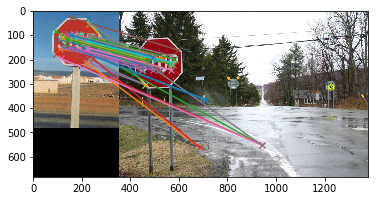

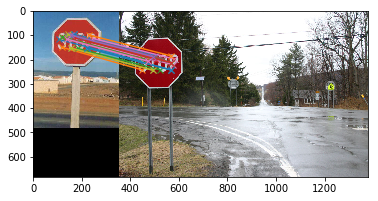

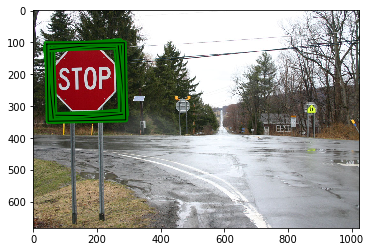

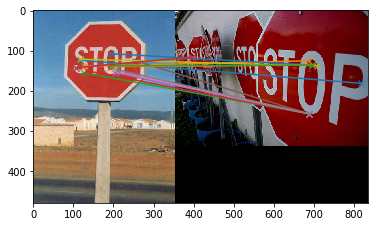

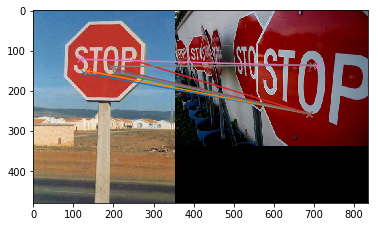

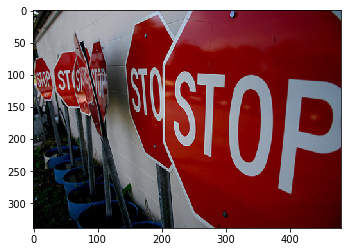

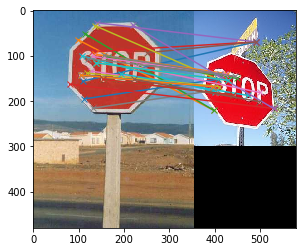

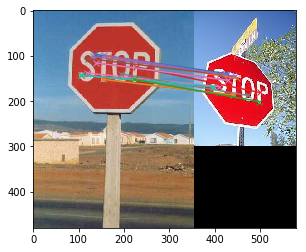

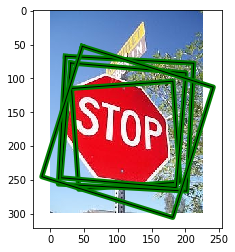

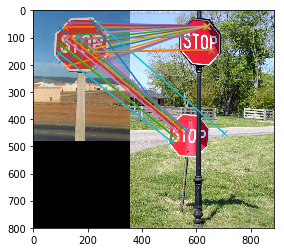

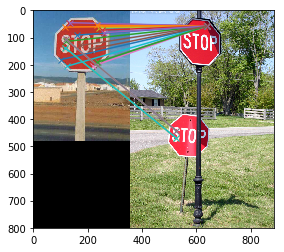

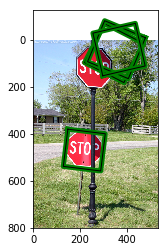

In [153]:
'''
MATCH_OBJECT: The pipeline for matching an object in one image with another

Arguments:
    im1 - The first image read in as a ndarray of size (H, W, C).

    descriptors1 - Descriptors corresponding to the first image. Each row
        corresponds to a descriptor. This is a ndarray of size (M_1, 128).

    keypoints1 - Keypoints in the first image. Each row is a SIFT keypoint
        consisting of (u, v, scale, theta). Overall, this variable is a ndarray
        of size (M_1, 4).

    im2 - The second image read in as a ndarray of size (H, W, C).

    descriptors2 - Descriptors corresponding to the second image. Each row
        corresponds to a descriptor. This is a ndarray of size (M_2, 128).

    keypoints2 - Keypoints in the second image. Each row is a SIFT keypoint
        consisting of (u, v, scale, theta). Overall, this variable is a ndarray
        of size (M_2, 4).

    obj_bbox - An ndarray of size (4,) that contains [xmin, ymin, xmax, ymax]
        of the bounding box. Note that the point (xmin, ymin) is one corner of
        the box and (xmax, ymax) is the opposite corner of the box.

Returns:
    descriptors - The descriptors corresponding to the keypoints inside the
        bounding box.

    keypoints - The pixel locations of the keypoints that reside in the 
        bounding box
'''
def match_object(im1, descriptors1, keypoints1, im2, descriptors2, keypoints2,
        obj_bbox):
    # Part A
    descriptors1, keypoints1, = select_keypoints_in_bbox(descriptors1,
        keypoints1, obj_bbox)
    matches = match_keypoints(descriptors1, descriptors2)
    plot_matches(im1, im2, keypoints1, keypoints2, matches)
    
    # Part B
    inliers, model = refine_match(keypoints1, keypoints2, matches)
    plot_matches(im1, im2, keypoints1, keypoints2, matches[inliers,:])

    # Part C
    cx, cy, w, h, orient = get_object_region(keypoints1, keypoints2,
        matches[inliers,:], obj_bbox)

    plot_bbox(cx, cy, w, h, orient, im2)


# Load the data
data = sio.loadmat('single_object_recognition/SIFT_data.mat')
images = data['stopim'][0]
obj_bbox = data['obj_bbox'][0]
keypoints = data['keypt'][0]
descriptors = data['sift_desc'][0]

np.random.seed(0)

for i in [2, 1, 3, 4]:
    match_object(images[0], descriptors[0], keypoints[0], images[i],
        descriptors[i], keypoints[i], obj_bbox)

# 3. Histogram of Oriented Gradients

In [182]:
import numpy as np
import skimage.io as sio
from scipy.io import loadmat
from hog.plotting import *
import math

## (a) Compute gradient

In [183]:
'''
COMPUTE_GRADIENT Given an image, computes the pixel gradients

Arguments:
    im - a grayscale image, represented as an ndarray of size (H, W) containing
        the pixel values

Returns:
    angles - ndarray of size (H-2, W-2) containing gradient angles in degrees

    magnitudes - ndarray of size (H-2, W-2) containing gradient magnitudes

The way that the angles and magnitude per pixel are computed as follows:
Given the following pixel grid

    P1 P2 P3
    P4 P5 P6
    P7 P8 P9

We compute the angle on P5 as arctan(dy/dx) = arctan(P2-P8 / P4-P6).
Note that we should be using np.arctan2, which is more numerically stable.
However, this puts us in the range [-180, 180] degrees. To be in the range
[0,180], we need to simply add 180 degrees to the negative angles.

The magnitude is simply sqrt((P4-P6)^2 + (P2-P8)^2)
'''
def compute_gradient(im):
    #print ("Image.shape\n", im.shape)
    #print ("Image\n", im[0:3, 0:3])
    p2p8 = im[0:im.shape[0] - 2, 1:im.shape[1]-1] - im[2:im.shape[0], 1:im.shape[1]-1]
    #print ("p2p8\n", p2p8[0:3, 0:3])
    p4p6 = im[1:im.shape[0]-1, 0:im.shape[1] - 2] - im[1:im.shape[0]-1, 2:im.shape[1]]
    #print ("p4p6\n", p4p6[0:3, 0:3])
    
    angles = np.arctan2(p2p8, p4p6) * 180 / np.pi
    angles [angles < 0] += 180
    magnitudes = np.sqrt(p2p8 * p2p8 + p4p6 * p4p6)
    
    #print ("angles\n", angles)
    #print ("magnitudes\n", magnitudes)
    return (angles, magnitudes)


In [184]:
# Part A: Checking the image gradient
print '-' * 80
print 'Part A: Image gradient'
print '-' * 80
im = sio.imread('hog/simple.jpg', True)
grad_angle, grad_magnitude = compute_gradient(im)
print "Expected angle: 126.339396329"
print "Expected magnitude: 0.423547566786"
print "Checking gradient test case 1:", \
    np.abs(grad_angle[0][0] - 126.339396329) < 1e-3 and \
    np.abs(grad_magnitude[0][0] - 0.423547566786) < 1e-3

im = np.array([[1, 2, 2, 4, 8],
                [3, 0, 1, 5, 10],
                [10, 13, 12, 2, 7],
                [10, 5, 1, 0, 3],
                [1, 1, 1.5, 2, 2.5]])
grad_angle, grad_magnitude = compute_gradient(im)
correct_angle = np.array([[ 100.30484647,   63.43494882,  167.47119229],
                          [  68.19859051,    0.        ,   45.        ],
                          [  53.13010235,   64.53665494,  180.        ]])
correct_magnitude = np.array([[ 11.18033989,  11.18033989,   9.21954446],
                              [  5.38516481,  11.        ,   7.07106781],
                              [ 15.        ,  11.62970335,   2.        ]])
print "Expected angles: \n", correct_angle
print "Expected magnitudes: \n", correct_magnitude
print "Checking gradient test case 2:", \
    np.allclose(grad_angle, correct_angle) and \
    np.allclose(grad_magnitude, correct_magnitude)

--------------------------------------------------------------------------------
Part A: Image gradient
--------------------------------------------------------------------------------
Expected angle: 126.339396329
Expected magnitude: 0.423547566786
Checking gradient test case 1: True
Expected angles: 
[[ 100.30484647   63.43494882  167.47119229]
 [  68.19859051    0.           45.        ]
 [  53.13010235   64.53665494  180.        ]]
Expected magnitudes: 
[[ 11.18033989  11.18033989   9.21954446]
 [  5.38516481  11.           7.07106781]
 [ 15.          11.62970335   2.        ]]
Checking gradient test case 2: True


## (b) Generate histogram

In [185]:
'''
GENERATE_HISTOGRAM Given matrices of angles and magnitudes of the image
gradient, generate the histogram of angles

Arguments:
    angles - ndarray of size (M, N) containing gradient angles in degrees

    magnitudes - ndarray of size (M, N) containing gradient magnitudes

    nbins - the number of bins that you want to bin the histogram into

Returns:
    histogram - an ndarray of size (nbins,) containing the distribution
        of gradient angles.

This method should be implemented as follows:

1)Each histogram will bin the angle from 0 to 180 degrees. The number of bins
will dictate what angles fall into what bin (i.e. if nbins=9, then first bin
will contain the votes of angles close to 10, the second bin will contain those
close to 30, etc).

2) To create these histogram, iterate over the gradient grids, putting each
gradient into its respective bins. To do this properly, we interpolate and
weight the voting by both its magnitude and how close it is to the average
angle of the two bins closest to the angle of the gradient. For example, if we
have nbins = 9 and receive angle of 20 degrees with magnitude 1, then we the
vote contribution to the histogram weights equally with the first and second bins
(since its closest to both 10 and 30 degrees). If instead, we recieve angle of
25 degrees with magnitude 2, then it is weighted 25% in the first bin and 75%
in second bin, but with twice the voting power.

Mathematically, if you have an angle, magnitude, the center_angle1 of the lower
bin center_angle2 of the higher bin, then:

histogram[bin1] += magnitude * |angle - center_angle2| / (180 / nbins) 
histogram[bin2] += magnitude * |angle - center_angle1| / (180 / nbins)

Notice how that we're weighting by the distance to the opposite center. The
further the angle is from one center means it is closer to the opposite center
(and should be weighted more).

One special case you will have to take care of is when the angle is near
180 degrees or 0 degrees. It may be that the two nearest bins are the first and
last bins respectively.OA
'''
def generate_histogram(angles, magnitudes, nbins = 9):
    histogram = np.zeros(nbins)
    bin_size = 180 / nbins
    centroids = np.zeros(nbins + 1)
    for idx in range(0, nbins + 1):
        centroids[idx] = bin_size * 1. / 2 + bin_size * idx
    
    #print ("centroids: \n", centroids)
    
    for idx1 in range(0, angles.shape[0]):
        for idx2 in range(0, angles.shape[1]):
            angle = angles[idx1, idx2]
            magnitude = magnitudes[idx1, idx2]
            for idx in range(0, nbins + 1):
                if angle == centroids[idx]:
                    histogram[idx] += magnitude
                    break
                if angle < centroids[idx]:
                    bin1 = idx
                    bin2 = idx - 1
                    center1 = centroids[bin1]
                    center2 = centroids[bin2]
                    
                    if idx == 0:
                        bin2 = nbins - 1
                        center2 = bin_size * (-1.) / 2
                    if idx == nbins:
                        bin1 = 0
                    
                    histogram[bin1] += magnitude * abs(angle - center2) / (180. / nbins)
                    histogram[bin2] += magnitude * abs(angle - center1) / (180. / nbins)
                    break

    return histogram

In [186]:
# Part B: Checking the histogram generation
print '-' * 80
print 'Part B: Histogram generation'
print '-' * 80
angles = np.array([[10, 30, 50], [70, 90, 110], [130, 150, 170]])
magnitudes = np.arange(1,10).reshape((3,3))
print "Checking histogram test case 1:", \
    np.all(generate_histogram(angles, magnitudes, nbins = 9) == np.arange(1,10))

angles = np.array([[20, 40, 60], [80, 100, 120], [140, 160, 180]])
magnitudes = np.arange(1,19,2).reshape((3,3))
histogram = generate_histogram(angles, magnitudes, nbins = 9)
print "Checking histogram test case 2:", \
    np.all(histogram  == np.array([9, 2, 4, 6, 8, 10, 12, 14, 16]))

angles = np.array([[13, 23, 14.3], [53, 108, 1], [77, 8, 32]])
magnitudes = np.ones((3,3)) 
histogram = generate_histogram(angles, magnitudes, nbins = 9)
print "Submit these results:", histogram

--------------------------------------------------------------------------------
Part B: Histogram generation
--------------------------------------------------------------------------------
Checking histogram test case 1: True
Checking histogram test case 2: True
Submit these results: [ 3.435  1.915  0.95   0.8    0.45   0.9    0.     0.     0.55 ]


## (c) Compute hog features

In [187]:
'''
COMPUTE_HOG_FEATURES Computes the histogram of gradients features
Arguments:
    im - the image matrix

    pixels_in_cell - each cell will be of size (pixels_in_cell, pixels_in_cell)
        pixels

    cells_in_block - each block will be of size (cells_in_block, cells_in_block)
        cells

    nbins - number of histogram bins

Returns:
    features - the hog features of the image represented as an ndarray of size
        (H_blocks, W_blocks, cells_in_block * cells_in_block * nbins), where
            H_blocks is the number of blocks that fit height-wise
            W_blocks is the number of blocks that fit width-wise

Generating the HoG features can be done as follows:

1) Compute the gradient for the image, generating angles and magnitudes

2) Define a cell, which is a grid of (pixels_in_cell, pixels_in_cell) pixels.
Also, define a block, which is a grid of (cells_in_block, cells_in_block) cells.
This means each block is a grid of side length pixels_in_cell * cell_in_block
pixels.

3) Pass a sliding window over the image, with the window size being the size of
a block. The stride of the sliding window should be half the block size, (50%
overlap). Each cell in each block will store a histogram of the gradients in
that cell. Consequently, there will be cells_in_block * cells_in_block
histograms in each block. This means that each block feature will initially
represented as a (cells_in_block, cells_in_block, nbins) ndarray, that can
reshaped into a (cells_in_block * cells_in_block *nbins,) ndarray. Make sure to
normalize such that the norm of this flattened block feature is 1. 

4) The overall hog feature that you return will be a grid of all these flattened
block features.

Note: The final overall feature ndarray can be flattened if you want to use to
train a classifier or use it as a feature vector.
'''
def compute_hog_features(im, pixels_in_cell, cells_in_block, nbins):
    angles, magnitudes = compute_gradient(im)
    window_size = pixels_in_cell * cells_in_block
    window_step = int(window_size / 2)
    
    def compute_hog_for_block(angles, magnitudes, h_start, w_start):
        #print ("angles\n", angles.shape)
        #print ("magnitudes\n", magnitudes.shape)
        hog_cells = np.zeros((cells_in_block, cells_in_block, nbins))
        for h_cell in range(0, cells_in_block):
            for w_cell in range(0, cells_in_block):
                h_pixels = range(
                    h_start + h_cell * pixels_in_cell,
                    h_start + (h_cell + 1) * pixels_in_cell)
                w_pixels = range(
                    w_start + w_cell * pixels_in_cell,
                    w_start + (w_cell + 1) * pixels_in_cell)
                #print ("h_pixels\n", h_pixels)
                #print ("w_pixels\n", w_pixels)
                cell_angles = angles[h_pixels, :][:, w_pixels]
                cell_magnitudes = magnitudes[h_pixels,:][:, w_pixels]
                #print ("cell_angles\n", cell_angles.shape)
                #print ("cell_magnitudes\n", cell_magnitudes.shape)
                histogram = generate_histogram(cell_angles, cell_magnitudes, nbins)
                hog_cells[h_cell, w_cell, :] = histogram
        
        block_hog = hog_cells.flatten()
        block_hog = block_hog * 1. / np.linalg.norm(block_hog)
        return block_hog
    
    h_blocks = len(range(0, angles.shape[0] - window_size, window_step))
    w_blocks = len(range(0, angles.shape[1] - window_size, window_step))
    
    hog_blocks = np.zeros((
        h_blocks, w_blocks,
        cells_in_block * cells_in_block * nbins))
    
    for idx_h in range(0, angles.shape[0] - window_size, window_step):
        h_block = int(idx_h / window_step)
        for idx_w in range(0, angles.shape[1] - window_size, window_step):
            w_block = int(idx_w / window_step)
            hog_for_block = compute_hog_for_block(angles, magnitudes, idx_h, idx_w)
            hog_blocks[h_block, w_block, :] = hog_for_block
    
    return hog_blocks

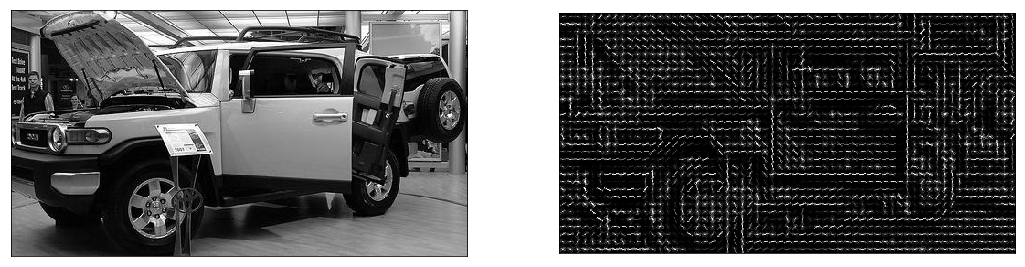

In [188]:
# Part C: Computing and displaying the final HoG features
# vary cell size to change the output feature vector. These parameters are common parameters
pixels_in_cell = 8
cells_in_block = 2
nbins = 9
im = sio.imread('hog/car.jpg', True)
car_hog_feat = compute_hog_features(im, pixels_in_cell, cells_in_block, nbins)
show_hog(im, car_hog_feat, figsize = (18,6))
